In [186]:
import torch
import pandas as pd
import numpy as np

import os

from collections import Counter

import spacy
import fasttext
import re
from nltk.corpus import stopwords

import lightgbm as lgb

import pickle

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_score, f1_score, recall_score, roc_auc_score, confusion_matrix, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import *
from sklearn.ensemble import BaggingClassifier
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import AutoModel, AutoTokenizer

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from clip_client import Client

from tqdm import tqdm

from joblib import Parallel, delayed

In [2]:
SEED = 42

# Load labeled data

In [173]:
PATH_DATA_LABELED = "data_new_new"

# df_list = []

# for file in os.listdir(PATH_DATA_LABELED):
#     df = pd.read_json(os.path.join(PATH_DATA_LABELED, file))
#     df_list.append(df)

# posts_labeled = pd.concat(df_list)
# posts_labeled.head(3)
posts_labeled = pd.read_json(os.path.join(PATH_DATA_LABELED, "data_labeled.json"))

In [174]:
# # Merge labels
# labels_merged = []
# for row in posts_labeled.itertuples():
#     label_przemek = row[14]
#     label_brandon = row[15]
#     label_sarthak = row[16]
    
#     # Neither Brandon's nor Sarthak's label present, pick Przemek's label
#     if not isinstance(label_brandon, str) and not isinstance(label_sarthak, str):
#         label = label_przemek
    
#     # all labels present, pick mode
#     elif isinstance(label_przemek, str) and isinstance(label_brandon, str) and isinstance(label_sarthak, str):
#     # elif not np.isnan(label_przemek and not np.isnan(label_brandon) and not np.isnan(label_sarthak)):
#         label = Counter([label_przemek, label_brandon, label_sarthak]).most_common(5)[0][0]
    
#     labels_merged.append(label)

# posts_labeled["label"] = labels_merged
Counter(posts_labeled["Final Label"])

Counter({'n': 374, 'c': 263, 'm': 365})

# Clean text data

In [175]:
texts = list(posts_labeled["Text"])
# texts = list(" ".join(comments) for comments in posts_labeled["Comments Text"])
labels = list(posts_labeled["Final Label"])
nlp = spacy.load("en_core_web_sm")

In [176]:
def clean_text(text, nlp):
    # # lowercase
    # text = text.lower()
    
    # remove non alphanum
    text = re.sub("[^a-zA-Z!?]", " ", text)
    
    # lemmatization
    tokens = [str(token.lemma_).strip() for token in nlp(text)]
    tokens = [token for token in tokens if token != ""]
    
    # remove stopwords
    tokens = [token for token in tokens if token not in stopwords.words()]
    
    return tokens

def clean_text_doc(doc):
    # lemmatization + lowercase + remove non-alphanumeric
    tokens = [re.sub("[^a-zA-Z!?]", " ", str(token.lemma_)).strip() for token in doc]
    tokens = [token for token in tokens if token != ""]
    
    # remove stopwords
    tokens = [token for token in tokens if token not in stopwords.words()]
    
    return tokens

In [177]:
# def preprocess_pipe(texts):
#     preproc_pipe = []
#     for doc in nlp.pipe(texts, batch_size=20):
#         preproc_pipe.append(clean_text_doc(doc))
#     return preproc_pipe

# text_clean = preprocess_pipe(texts)

In [178]:
# Kudos to this smart person: https://prrao87.github.io/blog/spacy/nlp/performance/2020/05/02/spacy-multiprocess.html#Option-3:-Parallelize-the-work-using-joblib
def chunker(iterable, total_length, chunksize):
    return (iterable[pos: pos + chunksize] for pos in range(0, total_length, chunksize))

def flatten(list_of_lists):
    "Flatten a list of lists to a combined list"
    return [item for sublist in list_of_lists for item in sublist]

def process_chunk(texts):
    preproc_pipe = []
    for doc in nlp.pipe(texts, batch_size=20):
        preproc_pipe.append(clean_text_doc(doc))
    return preproc_pipe

def preprocess_parallel(texts, chunksize=100):
    executor = Parallel(n_jobs=7, backend='multiprocessing', prefer="processes")
    do = delayed(process_chunk)
    tasks = (do(chunk) for chunk in chunker(texts, len(texts), chunksize=chunksize))
    result = executor(tasks)
    return flatten(result)

text_clean = preprocess_parallel(texts, chunksize=50)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [179]:
# text_clean = [clean_text(text, nlp) for text in tqdm(texts)]

text_clean_nonempty = []
labels_nonempty = []
idx_empty = []
# Exclude rows with empty clean text
for i in range(len(text_clean)):
    text = text_clean[i]
    label = labels[i]
    # Only save for nonempty text
    if len(text) != 0:
        text_clean_nonempty.append(text)
        labels_nonempty.append(label)
    else:
        idx_empty.append(i)
posts_labeled = posts_labeled.reset_index(drop=True)
posts_labeled = posts_labeled.drop(idx_empty)

In [180]:
texts[0:10]

['The voter awareness campaign through student skit organized by the Faculty of juridical sciences #RamaUniversity concluded successfully.#voterawareness #vote #follow #voterregistration #k #f #stolenelection #voting #yourvotematters #brandedmerchandise #productdesign #polls #wemakeitbetter #wemakeit #byharperandscott #discoverunder #blacklivesmatter #election #blackouttuesday #follo #followback #followed #follower',
 'The #truth vs. a #lie--the truth will not burn you. #StolenElection #SandyHook # #january6th #alexjones #thefatheroflies',
 'Was hoping LinkedIn was better than FB or Twitter... guess not.  #FJB #StolenElection',
 'Tik Tok...Tik Tok... #StolenElection #UnConstitutionalElection',
 '#DHS #whistleblowers share documents that label all who call the #Stolenelection real are now labeled #DVE. This is an attack on #freedomofspeech. It is an attack on YOU!',
 'If Republicans take back the House and Senate in November, the First order of business, all #Republicans must grow a set

In [181]:
text_clean_nonempty[0:10]

[['voter',
  'awareness',
  'campaign',
  'student',
  'skit',
  'organize',
  'Faculty',
  'juridical',
  'science',
  'RamaUniversity',
  'conclude',
  'successfully  voterawareness',
  'vote',
  'follow',
  'voterregistration',
  'f',
  'stolenelection',
  'vote',
  'yourvotematter',
  'brandedmerchandise',
  'productdesign',
  'poll',
  'wemakeitbetter',
  'wemakeit',
  'byharperandscott',
  'discoverunder',
  'blacklivesmatter',
  'election',
  'blackouttuesday',
  'follo',
  'followback',
  'follow',
  'follower'],
 ['truth',
  'vs',
  'lie',
  'truth',
  'burn',
  'StolenElection',
  'SandyHook',
  'january th',
  'alexjone',
  'thefatheroflie'],
 ['hope', 'LinkedIn', 'FB', 'Twitter', 'guess', 'FJB', 'StolenElection'],
 ['tik', 'tok', 'Tik', 'tok', 'StolenElection', 'unconstitutionalelection'],
 ['DHS',
  'whistleblower',
  'share',
  'document',
  'label',
  'call',
  'Stolenelection',
  'real',
  'label',
  'DVE',
  'attack',
  'freedomofspeech',
  'attack',
  '!'],
 ['Republi

# Vectorize text using pre-trained fastText vectors (300D)

In [182]:
# ft = fasttext.load_model('cc.en.300.bin')
# embeddings_fasttext = []
# for text in tqdm(text_clean_nonempty):
#     num_words = len(text)
#     if num_words == 0:
#         num_words = 1
#     vec = np.zeros((300, ))
#     for word in text:
#         vec += ft.get_word_vector(word)
#     vec /= num_words
#     embeddings_fasttext.append(vec)

# Vectorize using CLIP

In [225]:
LINK_CLIP_SERVER = "tcp://6.tcp.ngrok.io:17165".replace("tcp:", "grpc:")
print(LINK_CLIP_SERVER)
c = Client(LINK_CLIP_SERVER)
# Make sure there's output showing an alive connection
c.profile()

grpc://6.tcp.ngrok.io:17165


Roundtrip  244ms  100% 
├──  Client-server network  230ms  94% 
└──  Server  14ms  6% 
    ├──  Gateway-CLIP network  1ms  7% 
    └──  CLIP model  13ms  93%

{'Roundtrip': 244.17050900228787,
 'Client-server network': 230.17050900228787,
 'Server': 14,
 'Gateway-CLIP network': 1,
 'CLIP model': 13}

In [183]:
embeddings_clip = c.encode([" ".join(text) for text in text_clean_nonempty])

ERROR  GRPCClient@8847 gRPC error: StatusCode.UNAVAILABLE failed to connect to all addresses    [12/01/22 12:33:11]
       The ongoing request is terminated as the server is not available or closed already.                         

Exception in thread Thread-48:
Traceback (most recent call last):
  File "/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/jina/clients/base/grpc.py", line 133, in _get_results
    async for resp in stub.Call(
  File "/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/grpc/aio/_call.py", line 326, in _fetch_stream_responses
    await self._raise_for_status()
  File "/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/grpc/aio/_call.py", line 236, in _raise_for_status
    raise _create_rpc_error(await self.initial_metadata(), await
grpc.aio._call.AioRpcError: <AioRpcError of RPC that terminated with:
	status = StatusCode.UNAVAILABLE
	details = "failed to connect to all addresses"
	debug_error_string = "{"created":"@1669915991.987991979","description":"Failed to pick subchannel","file":"src/core/ext/filters/client_channel/client_channel.cc","

BadClient: something wrong when running the eventloop, result can not be retrieved

## Vectorize using MPNet (https://huggingface.co/docs/transformers/model_doc/mpnet)

In [ ]:
# model_mpnet = SentenceTransformer("all-mpnet-base-v2")
# embeddings_mpnet = model_mpnet.encode([" ".join(text) for text in text_clean_nonempty])

In [15]:
# Add features to embeddings
sentiment_analyzer = SentimentIntensityAnalyzer()
feature_vecs = []

for i in range(posts_labeled.shape[0]):
    emb = embeddings_clip[i]
    row = posts_labeled.iloc[i]
#     text = row["Text"]
    likes = int(re.sub(",", "", str(row.Likes)))
    comments = int(re.sub("[^0-9]", "", str(row.Comments)))
    reposts = int(re.sub("[^0-9]", "", str(row.Reposts)))
    n_words = len(text_clean_nonempty[i])
    sentiment = sentiment_analyzer.polarity_scores(" ".join(text_clean_nonempty[i]))["compound"]
    vec = np.concatenate([emb, np.array([likes, comments, reposts, n_words, sentiment])])
#     vec = np.array([likes, comments, reposts, n_words, sentiment])
    feature_vecs.append(vec)

# Train model

In [ ]:
def print_perf_metrics(preds, y_test, average="binary"):
    precision = precision_score(y_test, preds, average=average)
    recall = recall_score(y_test, preds, average=average)
    f1 = f1_score(y_test, preds, average=average)
    # Skip AUC when multiclass
    if average == "binary":
#     multi_class = "ovr" if average != "binary" else "raise"
        roc_auc = roc_auc_score(y_test, preds)

    print("precision: {}".format(round(precision, 3)))
    print("recall: {}".format(round(recall, 3)))
    print("f1: {}".format(round(f1, 3)))
    if average == "binary":
        print("AUC: {}".format(round(roc_auc, 3)))

In [ ]:
label_mapping = {"c": 0, "n": 0, "m": 1} # merge counter-misinfo and neutral into neutral (i.e. transform into a binary classification task)
labels_int = [label_mapping[label] for label in labels_nonempty]

X_train, X_test, y_train, y_test = train_test_split(embeddings_clip, labels_int, test_size=0.2, random_state=SEED)

## Logistic regression

In [ ]:
parameters_logreg = {
    "base_estimator__C": [0.1, 1, 10, 100, 1000],
    "base_estimator__penalty": ["l1", "l2", "elasticnet"],
#     "C": [0.1, 1, 10, 100, 1000],
#     "penalty": ["l1", "l2", "elasticnet"],
    "n_estimators": [10, 25, 50]
}
estimator_logreg = BaggingClassifier(LogisticRegression(max_iter=100000))
# estimator_logreg = LogisticRegression(max_iter=100000)

grid_search_logreg = GridSearchCV(
    estimator=estimator_logreg,
    param_grid=parameters_logreg,
    scoring="f1",
    n_jobs=-1,
    cv=10,
    verbose=2
)
grid_search_logreg.fit(X_train, y_train)
preds_logreg = grid_search_logreg.predict(X_test)

In [301]:
print_perf_metrics(preds_logreg, y_test)

precision: 0.71
recall: 0.564
f1: 0.629
AUC: 0.706


## SVM

In [27]:
parameters_svm = {
    "base_estimator__C": [0.1, 0.5, 1, 10, 100, 1000],
    "base_estimator__kernel": ["linear", "poly", "rbf", "sigmoid"],
    "n_estimators": [10, 25, 50]
}
estimator_svm = BaggingClassifier(SVC())

grid_search_svm = GridSearchCV(
    estimator=estimator_svm,
    param_grid=parameters_svm,
    scoring="f1_micro",
    n_jobs=-1,
    cv=10,
    verbose=2
)
grid_search_svm.fit(X_train, y_train)
preds_svm = grid_search_svm.predict(X_test)

Fitting 10 folds for each of 72 candidates, totalling 720 fits
[CV] END base_estimator__C=0.1, base_estimator__kernel=linear, n_estimators=10; total time=   6.2s
[CV] END base_estimator__C=0.1, base_estimator__kernel=linear, n_estimators=10; total time=   6.3s
[CV] END base_estimator__C=0.1, base_estimator__kernel=linear, n_estimators=10; total time=   6.3s
[CV] END base_estimator__C=0.1, base_estimator__kernel=linear, n_estimators=10; total time=   6.5s
[CV] END base_estimator__C=0.1, base_estimator__kernel=linear, n_estimators=10; total time=   6.3s
[CV] END base_estimator__C=0.1, base_estimator__kernel=linear, n_estimators=10; total time=   6.5s
[CV] END base_estimator__C=0.1, base_estimator__kernel=linear, n_estimators=10; total time=   6.4s
[CV] END base_estimator__C=0.1, base_estimator__kernel=linear, n_estimators=10; total time=   6.8s
[CV] END base_estimator__C=0.1, base_estimator__kernel=linear, n_estimators=10; total time=   6.6s
[CV] END base_estimator__C=0.1, base_estimator

In [28]:
print_perf_metrics(preds_svm, y_test)

precision: 0.793
recall: 0.59
f1: 0.676
AUC: 0.744


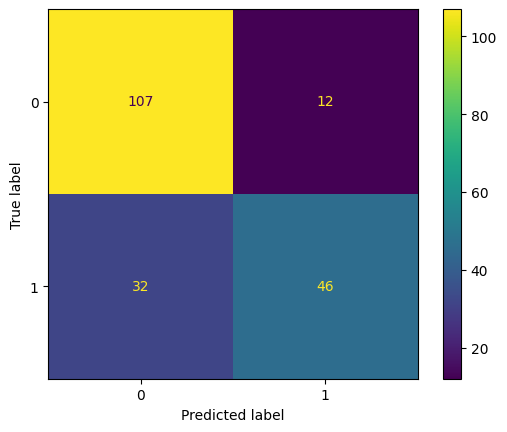

In [29]:
plot_confusion_matrix(grid_search_svm, X_test, y_test)

In [30]:
s = pickle.dumps(grid_search_svm)

In [31]:
s2 = pickle.loads(s)

In [32]:
print_perf_metrics(s2.predict(X_test), y_test)

precision: 0.793
recall: 0.59
f1: 0.676
AUC: 0.744


## Gaussian process

In [296]:
parameters_gaussian = {
    "kernel": [1*RBF(), 1*DotProduct(), 1*Matern(), 1*RationalQuadratic(), 1*WhiteKernel(), 1*ExpSineSquared()]
}
estimator_gaussian = GaussianProcessClassifier(n_jobs=1)

grid_search_gaussian = GridSearchCV(
    estimator=estimator_gaussian,
    param_grid=parameters_gaussian,
    scoring="f1",
    n_jobs=-1,
    cv=10,
    verbose=2
)
grid_search_gaussian.fit(X_train, y_train)
preds_gaussian = grid_search_gaussian.predict(X_test)

Fitting 10 folds for each of 6 candidates, totalling 60 fits
[CV] END ..................kernel=1**2 * RBF(length_scale=1); total time=  20.2s
[CV] END ..................kernel=1**2 * RBF(length_scale=1); total time=  21.4s
[CV] END ..................kernel=1**2 * RBF(length_scale=1); total time=  21.4s
[CV] END ..................kernel=1**2 * RBF(length_scale=1); total time=  21.4s
[CV] END ..................kernel=1**2 * RBF(length_scale=1); total time=  22.6s
[CV] END ..................kernel=1**2 * RBF(length_scale=1); total time=  24.8s
[CV] END ..................kernel=1**2 * RBF(length_scale=1); total time=  25.4s
[CV] END ..................kernel=1**2 * RBF(length_scale=1); total time=  27.1s
[CV] END ................kernel=1**2 * DotProduct(sigma_0=1); total time=  12.1s
[CV] END ................kernel=1**2 * DotProduct(sigma_0=1); total time=  14.8s
[CV] END ................kernel=1**2 * DotProduct(sigma_0=1); total time=  13.9s
[CV] END ..................kernel=1**2 * RBF(len

/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__alpha is close to the specified lower bound 1e-05. Decreasing th

[CV] END kernel=1**2 * RationalQuadratic(alpha=1, length_scale=1); total time=  10.9s
[CV] END kernel=1**2 * RationalQuadratic(alpha=1, length_scale=1); total time=  12.7s
[CV] END .......kernel=1**2 * Matern(length_scale=1, nu=1.5); total time=  26.6s


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END kernel=1**2 * RationalQuadratic(alpha=1, length_scale=1); total time=  11.7s


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END kernel=1**2 * RationalQuadratic(alpha=1, length_scale=1); total time=  12.8s
[CV] END .......kernel=1**2 * Matern(length_scale=1, nu=1.5); total time=  31.8s
[CV] END .......kernel=1**2 * Matern(length_scale=1, nu=1.5); total time=  28.3s


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END ...........kernel=1**2 * WhiteKernel(noise_level=1); total time=   1.1s
[CV] END kernel=1**2 * RationalQuadratic(alpha=1, length_scale=1); total time=  12.3s


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__alpha is close to the specified lower bound 1e-05. Decreasing th

[CV] END ...........kernel=1**2 * WhiteKernel(noise_level=1); total time=   1.1s
[CV] END ...........kernel=1**2 * WhiteKernel(noise_level=1); total time=   1.1s
[CV] END kernel=1**2 * RationalQuadratic(alpha=1, length_scale=1); total time=  11.3s
[CV] END kernel=1**2 * RationalQuadratic(alpha=1, length_scale=1); total time=  12.8s
[CV] END ...........kernel=1**2 * WhiteKernel(noise_level=1); total time=   1.1s
[CV] END ...........kernel=1**2 * WhiteKernel(noise_level=1); total time=   1.1s
[CV] END ...........kernel=1**2 * WhiteKernel(noise_level=1); total time=   1.1s
[CV] END ...........kernel=1**2 * WhiteKernel(noise_level=1); total time=   1.1s
[CV] END ...........kernel=1**2 * WhiteKernel(noise_level=1); total time=   1.1s


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END ...........kernel=1**2 * WhiteKernel(noise_level=1); total time=   1.1s
[CV] END kernel=1**2 * ExpSineSquared(length_scale=1, periodicity=1); total time=   0.8s
[CV] END ...........kernel=1**2 * WhiteKernel(noise_level=1); total time=   1.1s
[CV] END kernel=1**2 * ExpSineSquared(length_scale=1, periodicity=1); total time=   0.9s
[CV] END kernel=1**2 * RationalQuadratic(alpha=1, length_scale=1); total time=  11.1s
[CV] END kernel=1**2 * ExpSineSquared(length_scale=1, periodicity=1); total time=   0.9s
[CV] END kernel=1**2 * ExpSineSquared(length_scale=1, periodicity=1); total time=   0.9s
[CV] END kernel=1**2 * ExpSineSquared(length_scale=1, periodicity=1); total time=   0.9s
[CV] END kernel=1**2 * ExpSineSquared(length_scale=1, periodicity=1); total time=   1.0s
[CV] END kernel=1**2 * ExpSineSquared(length_scale=1, periodicity=1); total time=   0.9s
[CV] END kernel=1**2 * ExpSineSquared(length_scale=1, periodicity=1); total time=   0.9s
[CV] END kernel=1**2 * ExpSineSquared(le

/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__alpha is close to the specified lower bound 1e-05. Decreasing th

[CV] END kernel=1**2 * RationalQuadratic(alpha=1, length_scale=1); total time=   9.5s
[CV] END kernel=1**2 * RationalQuadratic(alpha=1, length_scale=1); total time=  10.8s
[CV] END .......kernel=1**2 * Matern(length_scale=1, nu=1.5); total time=  39.4s


12 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/sklearn/gaussian_process/_gpc.py", line 719, in fit
    self.base_estimator_.fit(X, y)
  File "/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/sklearn/gaussian_process/_gpc.py", line 224, in fit
    s

In [297]:
print_perf_metrics(preds_gaussian, y_test)

precision: 0.64
recall: 0.731
f1: 0.683
AUC: 0.731


## LightGBM

In [167]:
# parameters_lgb = {
#     "num_leaves": [10, 20, 50],
#     "num_iterations": [50, 100, 200],
#     "learning_rate": [0.01, 0.1],
#     "max_depth": [-1, 10, 50],
#     "min_data_in_leaf": [1, 10, 100, 1000]
# }
parameters_lgb = {
    "num_leaves": [10, 50],
    "num_iterations": [100, 500],
    "learning_rate": [0.01, 0.1],
    "max_depth": [-1, 10],
    "min_data_in_leaf": [10, 100, 500]
}
estimator_lgb = lgb.LGBMClassifier(objective="binary", random_state=SEED)
grid_search_lgb = GridSearchCV(
    estimator=estimator_lgb,
    param_grid=parameters_lgb,
    scoring="f1",
    n_jobs=-1,
    cv=5,
    verbose=2
)
grid_search_lgb.fit(X_train, y_train)
preds_lgb = grid_search_lgb.predict(X_test)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKE

/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=10, num_iterations=100, num_leaves=10; total time=   6.6s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=10, num_iterations=100, num_leaves=10; total time=   7.0s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=10, num_iterations=100, num_leaves=10; total time=   6.8s
[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=10, num_iterations=100, num_leaves=10; total time=   7.1s
[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=10, num_iterations=100, num_leaves=10; total time=   6.7s


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=10, num_iterations=100, num_leaves=50; total time=  17.9s
[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=10, num_iterations=100, num_leaves=50; total time=  17.9s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=10, num_iterations=100, num_leaves=50; total time=  19.2s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=10, num_iterations=100, num_leaves=50; total time=  17.3s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=10, num_iterations=100, num_leaves=50; total time=  17.2s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=10, num_iterations=500, num_leaves=10; total time=  31.3s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=10, num_iterations=500, num_leaves=10; total time=  31.5s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=10, num_iterations=500, num_leaves=10; total time=  32.1s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=100, num_iterations=100, num_leaves=10; total time=   1.6s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=100, num_iterations=100, num_leaves=10; total time=   1.6s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=100, num_iterations=100, num_leaves=10; total time=   1.8s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=100, num_iterations=100, num_leaves=10; total time=   2.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=100, num_iterations=100, num_leaves=10; total time=   1.9s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=10, num_iterations=500, num_leaves=10; total time=  31.0s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=10, num_iterations=500, num_leaves=10; total time=  31.7s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=100, num_iterations=100, num_leaves=50; total time=   1.7s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=100, num_iterations=100, num_leaves=50; total time=   1.6s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=100, num_iterations=100, num_leaves=50; total time=   1.7s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=100, num_iterations=100, num_leaves=50; total time=   1.9s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=100, num_iterations=100, num_leaves=50; total time=   1.9s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=100, num_iterations=500, num_leaves=10; total time=   7.1s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=100, num_iterations=500, num_leaves=10; total time=   6.7s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=100, num_iterations=500, num_leaves=10; total time=   7.5s


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=100, num_iterations=500, num_leaves=10; total time=   7.5s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=100, num_iterations=500, num_leaves=50; total time=   7.1s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=100, num_iterations=500, num_leaves=10; total time=   7.5s


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=100, num_iterations=500, num_leaves=50; total time=   6.5s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=100, num_iterations=500, num_leaves=50; total time=   7.4s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=500, num_iterations=100, num_leaves=10; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=500, num_iterations=100, num_leaves=10; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=500, num_iterations=100, num_leaves=10; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=500, num_iterations=100, num_leaves=10; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=500, num_iterations=100, num_leaves=10; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=100, num_iterations=500, num_leaves=50; total time=   7.4s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=500, num_iterations=100, num_leaves=50; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=500, num_iterations=100, num_leaves=50; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=500, num_iterations=100, num_leaves=50; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=500, num_iterations=100, num_leaves=50; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01,

/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration

[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=500, num_iterations=500, num_leaves=10; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=500, num_iterations=500, num_leaves=10; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=500, num_iterations=500, num_leaves=10; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration

[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=500, num_iterations=500, num_leaves=10; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=500, num_iterations=500, num_leaves=10; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=500, num_iterations=500, num_leaves=50; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=500, num_iterations=500, num_leaves=50; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration

[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=500, num_iterations=500, num_leaves=50; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=500, num_iterations=500, num_leaves=50; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=500, num_iterations=500, num_leaves=50; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=100, num_iterations=500, num_leaves=50; total time=   7.9s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=10, num_iterations=100, num_leaves=10; total time=   6.8s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=10, num_iterations=100, num_leaves=10; total time=   7.2s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=10, num_iterations=100, num_leaves=10; total time=   7.3s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=10, num_iterations=100, num_leaves=10; total time=   7.3s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=10, num_iterations=100, num_leaves=10; total time=   7.9s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=10, num_iterations=100, num_leaves=50; total time=  17.0s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=10, num_iterations=500, num_leaves=50; total time= 1.5min
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=10, num_iterations=100, num_leaves=50; total time=  19.9s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=10, num_iterations=100, num_leaves=50; total time=  21.0s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=10, num_iterations=500, num_leaves=50; total time= 1.5min
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=10, num_iterations=500, num_leaves=50; total time= 1.5min
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=10, num_iterations=100, num_leaves=50; total time=  16.7s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=10, num_iterations=100, num_leaves=50; total time=  15.5s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=10, num_iterations=500, num_leaves=50; total time= 1.5min
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=10, num_iterations=500, num_leaves=50; total time= 1.5min
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=10, num_iterations=500, num_leaves=10; total time=  33.6s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=10, num_iterations=500, num_leaves=10; total time=  33.2s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=10, num_iterations=500, num_leaves=10; total time=  31.8s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=10, num_iterations=500, num_leaves=10; total time=  32.5s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=100, num_iterations=100, num_leaves=10; total time=   1.5s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=100, num_iterations=100, num_leaves=10; total time=   1.7s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=100, num_iterations=100, num_leaves=10; total time=   1.4s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=100, num_iterations=100, num_leaves=10; total time=   1.6s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=100, num_iterations=100, num_leaves=10; total time=   1.7s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=100, num_iterations=100, num_leaves=50; total time=   1.6s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=100, num_iterations=100, num_leaves=50; total time=   1.5s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=100, num_iterations=100, num_leaves=50; total time=   1.4s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=100, num_iterations=100, num_leaves=50; total time=   1.7s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=100, num_iterations=100, num_leaves=50; total time=   1.8s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=10, num_iterations=500, num_leaves=10; total time=  32.7s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=100, num_iterations=500, num_leaves=10; total time=   7.1s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=100, num_iterations=500, num_leaves=10; total time=   7.4s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=100, num_iterations=500, num_leaves=10; total time=   6.5s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=100, num_iterations=500, num_leaves=10; total time=   8.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=100, num_iterations=500, num_leaves=50; total time=   7.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=100, num_iterations=500, num_leaves=10; total time=   8.5s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=100, num_iterations=500, num_leaves=50; total time=   8.6s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=100, num_iterations=500, num_leaves=50; total time=   8.7s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=500, num_iterations=100, num_leaves=10; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=500, num_iterations=100, num_leaves=10; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=500, num_iterations=100, num_leaves=10; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=500, num_iterations=100, num_leaves=10; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=500, num_iterations=100, num_leaves=10; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=500, num_iterations=100, num_leaves=50; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=500, num_iterations=100, num_leaves=50; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=500, num_iterations=100, num_leaves=50; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=500, num_iterations=100, num_leaves=50; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=500, num_iterations=100, num_leaves=50; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=500, num_iterations=500, num_leaves=10; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=500, num_iterations=500, num_leaves=10; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=500, num_iterations=500, num_leaves=10; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=100, num_iterations=500, num_leaves=50; total time=   9.7s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=500, num_iterations=500, num_leaves=10; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration

[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=500, num_iterations=500, num_leaves=10; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=500, num_iterations=500, num_leaves=50; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=500, num_iterations=500, num_leaves=50; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=500, num_iterations=500, num_leaves=50; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=500, num_iterations=500, num_leaves=50; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=500, num_iterations=500, num_leaves=50; total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=100, num_iterations=500, num_leaves=50; total time=   9.3s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=10, num_iterations=100, num_leaves=10; total time=   8.9s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=10, num_iterations=100, num_leaves=10; total time=   9.1s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=10, num_iterations=100, num_leaves=10; total time=   7.8s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=10, num_iterations=100, num_leaves=10; total time=   7.5s
[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=10, num_iterations=100, num_leaves=10; total time=   7.3s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=10, num_iterations=500, num_leaves=50; total time= 1.4min
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=10, num_iterations=100, num_leaves=50; total time=  20.8s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=10, num_iterations=100, num_leaves=50; total time=  18.6s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=10, num_iterations=500, num_leaves=50; total time= 1.5min
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=10, num_iterations=100, num_leaves=50; total time=  21.1s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=10, num_iterations=500, num_leaves=50; total time= 1.5min
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=10, num_iterations=100, num_leaves=50; total time=  19.3s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=10, num_iterations=500, num_leaves=50; total time= 1.5min
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=10, num_iterations=100, num_leaves=50; total time=  19.4s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=10, num_iterations=500, num_leaves=50; total time= 1.5min
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=10, num_iterations=500, num_leaves=10; total time=  24.3s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=10, num_iterations=500, num_leaves=10; total time=  23.1s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=10, num_iterations=500, num_leaves=10; total time=  25.6s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=10, num_iterations=500, num_leaves=10; total time=  24.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=100, num_iterations=100, num_leaves=10; total time=   1.8s
[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=100, num_iterations=100, num_leaves=10; total time=   2.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=100, num_iterations=100, num_leaves=10; total time=   1.6s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=100, num_iterations=100, num_leaves=10; total time=   1.6s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=100, num_iterations=100, num_leaves=10; total time=   1.6s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=100, num_iterations=100, num_leaves=50; total time=   1.8s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=100, num_iterations=100, num_leaves=50; total time=   1.7s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=100, num_iterations=100, num_leaves=50; total time=   1.9s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=100, num_iterations=100, num_leaves=50; total time=   2.0s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=100, num_iterations=100, num_leaves=50; total time=   2.1s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=10, num_iterations=500, num_leaves=10; total time=  24.5s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=100, num_iterations=500, num_leaves=10; total time=   7.8s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=100, num_iterations=500, num_leaves=10; total time=   7.8s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=100, num_iterations=500, num_leaves=10; total time=   8.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=10, num_iterations=500, num_leaves=50; total time=  33.8s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=10, num_iterations=500, num_leaves=50; total time=  32.5s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=10, num_iterations=500, num_leaves=50; total time=  33.1s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=100, num_iterations=500, num_leaves=10; total time=   8.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=100, num_iterations=500, num_leaves=10; total time=   8.6s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=500, num_iterations=100, num_leaves=10; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=500, num_iterations=100, num_leaves=10; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=500, num_iterations=100, num_leaves=10; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=500, num_iterations=100, num_leaves=10; total time=   0.1s


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=500, num_iterations=100, num_leaves=10; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=500, num_iterations=100, num_leaves=50; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=500, num_iterations=100, num_leaves=50; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=500, num_iterations=100, num_leaves=50; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=500, num_iterations=100, num_leaves=50; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=500, num_iterations=100, num_leaves=50; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=500, num_iterations=500, num_leaves=10; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=500, num_iterations=500, num_leaves=10; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=500, num_iterations=500, num_leaves=10; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=500, num_iterations=500, num_leaves=10; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=500, num_iterations=500, num_leaves=10; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=100, num_iterations=500, num_leaves=50; total time=   7.9s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=500, num_iterations=500, num_leaves=50; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=500, num_iterations=500, num_leaves=50; total time=   0.1s


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration

[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=500, num_iterations=500, num_leaves=50; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=500, num_iterations=500, num_leaves=50; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=500, num_iterations=500, num_leaves=50; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=10, num_iterations=500, num_leaves=50; total time=  32.3s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=100, num_iterations=500, num_leaves=50; total time=   7.0s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=100, num_iterations=500, num_leaves=50; total time=   7.9s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=10, num_iterations=500, num_leaves=50; total time=  33.8s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=100, num_iterations=500, num_leaves=50; total time=   8.4s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=100, num_iterations=500, num_leaves=50; total time=   8.0s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=10, num_iterations=100, num_leaves=10; total time=   7.3s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=10, num_iterations=100, num_leaves=10; total time=   7.2s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=10, num_iterations=100, num_leaves=10; total time=   8.8s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=10, num_iterations=100, num_leaves=10; total time=   7.3s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=10, num_iterations=100, num_leaves=10; total time=   7.0s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=10, num_iterations=100, num_leaves=50; total time=  18.2s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=10, num_iterations=100, num_leaves=50; total time=  18.2s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=10, num_iterations=100, num_leaves=50; total time=  18.8s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=10, num_iterations=100, num_leaves=50; total time=  18.5s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=10, num_iterations=100, num_leaves=50; total time=  18.1s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=10, num_iterations=500, num_leaves=10; total time=  24.1s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=10, num_iterations=500, num_leaves=10; total time=  23.2s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=10, num_iterations=500, num_leaves=10; total time=  24.1s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=100, num_iterations=100, num_leaves=10; total time=   2.0s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=100, num_iterations=100, num_leaves=10; total time=   1.6s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=100, num_iterations=100, num_leaves=10; total time=   1.8s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=100, num_iterations=100, num_leaves=10; total time=   1.9s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=100, num_iterations=100, num_leaves=10; total time=   1.8s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=100, num_iterations=100, num_leaves=50; total time=   1.7s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=10, num_iterations=500, num_leaves=10; total time=  24.0s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=10, num_iterations=500, num_leaves=10; total time=  23.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=100, num_iterations=100, num_leaves=50; total time=   1.6s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=100, num_iterations=100, num_leaves=50; total time=   1.6s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=100, num_iterations=100, num_leaves=50; total time=   1.8s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=100, num_iterations=100, num_leaves=50; total time=   1.7s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=100, num_iterations=500, num_leaves=10; total time=   7.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=10, num_iterations=500, num_leaves=50; total time=  30.5s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=100, num_iterations=500, num_leaves=10; total time=   7.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=100, num_iterations=500, num_leaves=10; total time=   7.7s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=10, num_iterations=500, num_leaves=50; total time=  30.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=10, num_iterations=500, num_leaves=50; total time=  30.4s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=100, num_iterations=500, num_leaves=10; total time=   8.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=100, num_iterations=500, num_leaves=10; total time=   8.2s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=500, num_iterations=100, num_leaves=10; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=500, num_iterations=100, num_leaves=10; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=500, num_iterations=100, num_leaves=10; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=500, num_iterations=100, num_leaves=10; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=500, num_iterations=100, num_leaves=10; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=500, num_iterations=100, num_leaves=50; total time=   0.1s


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=500, num_iterations=100, num_leaves=50; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=100, num_iterations=500, num_leaves=50; total time=   8.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=500, num_iterations=100, num_leaves=50; total time=   0.1s


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration

[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=500, num_iterations=100, num_leaves=50; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=500, num_iterations=100, num_leaves=50; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=500, num_iterations=500, num_leaves=10; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=100, num_iterations=500, num_leaves=50; total time=   7.8s
[LightGBM] [Warning] min_data_in

/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration


[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=500, num_iterations=500, num_leaves=10; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=500, num_iterations=500, num_leaves=10; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=500, num_iterations=500, num_leaves=10; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=500, num_iterations=500, num_leaves=50; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=500, num_iterations=500, num_leaves=10; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf

/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration

[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=500, num_iterations=500, num_leaves=50; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=500, num_iterations=500, num_leaves=50; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=100, num_iterations=500, num_leaves=50; total time=   7.9s
[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=500, num_iterations=500, num_leaves=50; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=500, num_iterations=500, num_leaves=50; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=100, num_iterations=500, num_leaves=50; total time=   7.8s
[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=10, num_iterations=500, num_leaves=50; total time=  31.3s
[CV] END learning_rate=0.1, max_depth=10, min_data_

In [63]:
print_perf_metrics(preds_lgb, y_test)

precision: 0.75
recall: 0.654
f1: 0.699
AUC: 0.755


In [184]:
print_perf_metrics(preds_lgb, y_test)

precision: 0.633
recall: 0.339
f1: 0.442
AUC: 0.609


In [21]:
# 3-class
precision = precision_score(y_test, preds_lgb, average="micro")
recall = recall_score(y_test, preds_lgb, average="micro")
f1 = f1_score(y_test, preds_lgb, average="micro")
# roc_auc = roc_auc_score(y_test, preds_lgb)

print("precision: {}".format(round(precision, 3)))
print("recall: {}".format(round(recall, 3)))
print("f1: {}".format(round(f1, 3)))
# print("AUC: {}".format(round(roc_auc, 3)))

precision: 0.609
recall: 0.609
f1: 0.609


In [22]:
pickle_lgb = pickle.dumps(grid_search_lgb)

In [23]:
lgb_from_pickle = pickle.loads(pickle_lgb)

## XGBoost

In [303]:
parameters = {
    'max_depth': range (2, 10, 2),
    'n_estimators': range(100, 500, 100),
    'learning_rate': [0.1, 0.05, 0.01]
}

estimator = XGBClassifier(
    objective= 'binary:logistic',
    nthread=-1,
    seed=SEED
)

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring='f1',
    n_jobs=1,
    cv=10,
    verbose=2
)

grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 48 candidates, totalling 480 fits
[CV] END ...learning_rate=0.1, max_depth=2, n_estimators=100; total time=   1.2s
[CV] END ...learning_rate=0.1, max_depth=2, n_estimators=100; total time=   1.1s
[CV] END ...learning_rate=0.1, max_depth=2, n_estimators=100; total time=   1.2s
[CV] END ...learning_rate=0.1, max_depth=2, n_estimators=100; total time=   1.3s
[CV] END ...learning_rate=0.1, max_depth=2, n_estimators=100; total time=   1.3s
[CV] END ...learning_rate=0.1, max_depth=2, n_estimators=100; total time=   1.2s
[CV] END ...learning_rate=0.1, max_depth=2, n_estimators=100; total time=   1.4s
[CV] END ...learning_rate=0.1, max_depth=2, n_estimators=100; total time=   1.3s
[CV] END ...learning_rate=0.1, max_depth=2, n_estimators=100; total time=   1.2s
[CV] END ...learning_rate=0.1, max_depth=2, n_estimators=100; total time=   1.2s
[CV] END ...learning_rate=0.1, max_depth=2, n_estimators=200; total time=   2.6s
[CV] END ...learning_rate=0.1, max_depth=2, n_

GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None, nthread=-1,
                                     num_parallel_tree=None, predictor=None, ...),
             n_jobs=1,
             param_grid={'learning_rate': [0.1, 0.05, 0.01],
                         'max_depth': range(2, 10, 2),
                         'n_estimators': range(100, 500, 100)},
             scoring='f1', verbose=2)

In [304]:
preds = grid_search.predict(X_test)
preds_proba = grid_search.predict_proba(X_test)[:, 1] >= 0.5

print_perf_metrics(preds_proba, y_test)

precision: 0.741
recall: 0.551
f1: 0.632
AUC: 0.713


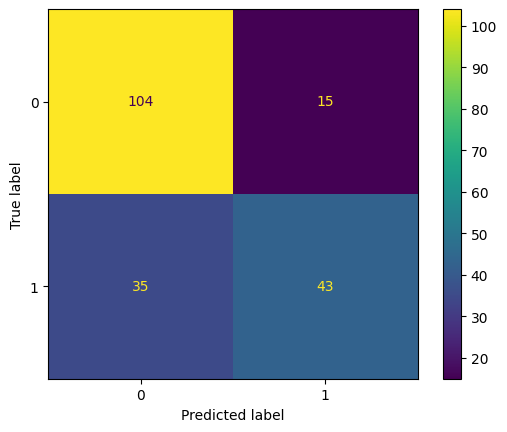

In [305]:
plot_confusion_matrix(grid_search, X_test, y_test)

## Random Forest

In [42]:
param_grid = {
    "n_estimators": range(50, 500, 100),
    "max_depth": range(10, 50, 10),
    "min_samples_leaf": range(1, 60, 10)
}

rf = RandomForestClassifier(
    n_jobs=-1
)

grid_search_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring="f1_micro",
    n_jobs =1,
    cv=10,
    verbose=2
)

grid_search_rf.fit(X_train, y_train)

Fitting 10 folds for each of 120 candidates, totalling 1200 fits
[CV] END ..max_depth=10, min_samples_leaf=1, n_estimators=50; total time=   3.5s
[CV] END ..max_depth=10, min_samples_leaf=1, n_estimators=50; total time=   0.4s
[CV] END ..max_depth=10, min_samples_leaf=1, n_estimators=50; total time=   0.4s
[CV] END ..max_depth=10, min_samples_leaf=1, n_estimators=50; total time=   0.4s
[CV] END ..max_depth=10, min_samples_leaf=1, n_estimators=50; total time=   0.4s
[CV] END ..max_depth=10, min_samples_leaf=1, n_estimators=50; total time=   0.4s
[CV] END ..max_depth=10, min_samples_leaf=1, n_estimators=50; total time=   0.4s
[CV] END ..max_depth=10, min_samples_leaf=1, n_estimators=50; total time=   0.4s
[CV] END ..max_depth=10, min_samples_leaf=1, n_estimators=50; total time=   0.4s
[CV] END ..max_depth=10, min_samples_leaf=1, n_estimators=50; total time=   0.4s
[CV] END .max_depth=10, min_samples_leaf=1, n_estimators=150; total time=   0.9s
[CV] END .max_depth=10, min_samples_leaf=1, 

GridSearchCV(cv=10, estimator=RandomForestClassifier(n_jobs=-1), n_jobs=1,
             param_grid={'max_depth': range(10, 50, 10),
                         'min_samples_leaf': range(1, 60, 10),
                         'n_estimators': range(50, 500, 100)},
             scoring='f1_micro', verbose=2)

In [45]:
estimator_best = grid_search_rf.best_estimator_
preds_rf = grid_search_rf.predict(X_test)
preds_proba_rf = grid_search_rf.predict_proba(X_test)

precision_rf = precision_score(y_test, preds_rf)
f1_rf = f1_score(y_test, preds_rf)
roc_auc_rf = roc_auc_score(y_test, preds_rf)

print("precision: {}".format(round(precision_rf, 3)))
print("f1: {}".format(round(f1_rf, 3)))
print("AUC: {}".format(round(roc_auc_rf, 3)))

precision: 1.0
f1: 0.49
AUC: 0.662


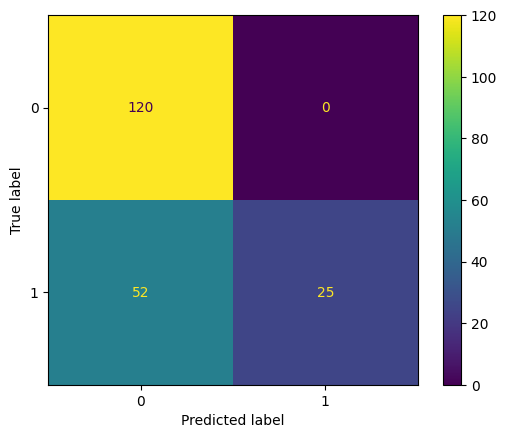

In [46]:
plot_confusion_matrix(grid_search_rf, X_test, y_test)

# Label all posts scraped so far

In [24]:
posts_unlabeled = pd.read_json("data_new_new/data_unlabeled.json")
# Exclude posts with no text
posts_unlabeled = posts_unlabeled[posts_unlabeled["Text"].apply(lambda x: len(x) > 0)]
posts_unlabeled.shape

(7366, 16)

In [25]:
# Exclude rows with empty text after cleaning
texts_cleaned_unlabeled = preprocess_parallel(list(posts_unlabeled["Text"]), chunksize=100)
idx_empty_cleaned = [i for i in range(len(texts_cleaned_unlabeled)) if len(texts_cleaned_unlabeled[i]) == 0]
texts_cleaned_unlabeled = [text for text in texts_cleaned_unlabeled if len(text) > 0]

posts_unlabeled = posts_unlabeled.reset_index()
posts_unlabeled = posts_unlabeled.drop(idx_empty_cleaned)

In [26]:
embeddings_unlabeled = c.encode([" ".join(text) for text in texts_cleaned_unlabeled])

In [27]:
# Predict labels
labels_for_unlabeled = lgb_from_pickle.predict(embeddings_unlabeled)
posts_unlabeled["label_predicted"] = labels_for_unlabeled

In [28]:
Counter(labels_for_unlabeled)

Counter({2: 2350, 1: 4466, 0: 538})

In [29]:
posts_unlabeled.to_json("data_labeled_lf_3class.json")

In [31]:
posts_unlabeled.columns

Index(['index', 'Name', 'Biography', 'Date', 'Text', 'Comments Text', 'Likes',
       'Comments', 'Reposts', 'Media Type', 'Media Link', 'Article Title',
       'Article Link', 'Article Description', 'Query', 'Query Date',
       'Language', 'label_predicted'],
      dtype='object')

# Train models for counter vs non-misinfo

In [94]:
# Prepare data
posts_counter_non = posts_labeled[posts_labeled["Final Label"].isin(["c", "n"])]
text_clean_counter_non = preprocess_parallel(posts_counter_non["Text"], chunksize=100)
label_mapping_counter_non = {"c": 0, "n": 1}
labels_counter_non = [label_mapping_counter_non[label] for label in posts_counter_non["Final Label"]]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [96]:
embeddings_clip_counter_non = c.encode([" ".join(text) for text in text_clean_counter_non])

X_train_counter_non, X_test_counter_non, y_train_counter_non, y_test_counter_non = train_test_split(embeddings_clip_counter_non, labels_counter_non, test_size=0.2, random_state=SEED)

In [100]:
estimator_lgb_counter_non = lgb.LGBMClassifier(objective="binary", random_state=SEED)
grid_search_lgb_counter_non = GridSearchCV(
    estimator=estimator_lgb_counter_non,
    param_grid=parameters_lgb,
    scoring="f1",
    n_jobs=-1,
    cv=5,
    verbose=2
)
grid_search_lgb_counter_non.fit(X_train_counter_non, y_train_counter_non)
preds_lgb_counter_non = grid_search_lgb_counter_non.predict(X_test_counter_non)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration

[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=10, num_iterations=100, num_leaves=10; total time=   5.9s
[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=10, num_iterations=100, num_leaves=10; total time=   5.9s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10



/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=10, num_iterations=100, num_leaves=10; total time=   6.3s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=10, num_iterations=100, num_leaves=10; total time=   6.4s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=10, num_iterations=100, num_leaves=10; total time=   6.4s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=10, num_iterations=100, num_leaves=50; total time=  13.5s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=10, num_iterations=100, num_leaves=50; total time=  14.1s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=10, num_iterations=100, num_leaves=50; total time=  14.5s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=10, num_iterations=100, num_leaves=50; total time=  13.5s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=10, num_iterations=100, num_leaves=50; total time=  14.7s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=10, num_iterations=500, num_leaves=10; total time=  26.4s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=10, num_iterations=500, num_leaves=10; total time=  26.9s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=10, num_iterations=500, num_leaves=10; total time=  27.4s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=100, num_iterations=100, num_leaves=10; total time=   1.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=100, num_iterations=100, num_leaves=10; total time=   1.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=100, num_iterations=100, num_leaves=10; total time=   1.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=100, num_iterations=100, num_leaves=10; total time=   1.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=10, num_iterations=500, num_leaves=10; total time=  25.7s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=100, num_iterations=100, num_leaves=10; total time=   1.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=10, num_iterations=500, num_leaves=10; total time=  26.6s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=100, num_iterations=100, num_leaves=50; total time=   1.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=100, num_iterations=100, num_leaves=50; total time=   1.4s


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=100, num_iterations=100, num_leaves=50; total time=   1.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=100, num_iterations=100, num_leaves=50; total time=   1.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=100, num_iterations=100, num_leaves=50; total time=   1.4s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=100, num_iterations=500, num_leaves=10; total time=   5.4s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=100, num_iterations=500, num_leaves=10; total time=   5.1s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=100, num_iterations=500, num_leaves=10; total time=   5.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=100, num_iterations=500, num_leaves=10; total time=   5.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=100, num_iterations=500, num_leaves=10; total time=   5.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=100, num_iterations=500, num_leaves=50; total time=   5.1s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=100, num_iterations=500, num_leaves=50; total time=   5.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=100, num_iterations=500, num_leaves=50; total time=   5.0s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=500, num_iterations=100, num_leaves=10; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=100, num_iterations=500, num_leaves=50; total time=   5.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=500, num_iterations=100, num_leaves=10; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration

[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=500, num_iterations=100, num_leaves=10; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=500, num_iterations=100, num_leaves=10; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=500, num_iterations=100, num_leaves=10; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=500, num_iterations=100, num_leaves=50; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01,

/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration


[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=500, num_iterations=100, num_leaves=50; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=500, num_iterations=100, num_leaves=50; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=500, num_iterations=100, num_leaves=50; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration

[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=500, num_iterations=500, num_leaves=10; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=500, num_iterations=500, num_leaves=10; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=500, num_iterations=500, num_leaves=10; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=500, num_iterations=500, num_leaves=10; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration

[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=500, num_iterations=500, num_leaves=10; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=500, num_iterations=500, num_leaves=50; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=500, num_iterations=500, num_leaves=50; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=500, num_iterations=500, num_leaves=50; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration

[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=500, num_iterations=500, num_leaves=50; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=500, num_iterations=500, num_leaves=50; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=100, num_iterations=500, num_leaves=50; total time=   5.3s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=10, num_iterations=100, num_leaves=10; total time=   5.5s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=10, num_iterations=100, num_leaves=10; total time=   5.5s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=10, num_iterations=100, num_leaves=10; total time=   5.4s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=10, num_iterations=100, num_leaves=10; total time=   5.4s
[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=10, num_iterations=100, num_leaves=10; total time=   5.4s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=10, num_iterations=500, num_leaves=50; total time= 1.0min
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=10, num_iterations=100, num_leaves=50; total time=  12.0s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=10, num_iterations=500, num_leaves=50; total time= 1.0min
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=10, num_iterations=100, num_leaves=50; total time=  12.4s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=10, num_iterations=100, num_leaves=50; total time=  12.4s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=10, num_iterations=500, num_leaves=50; total time= 1.0min
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=10, num_iterations=100, num_leaves=50; total time=  12.1s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=10, num_iterations=100, num_leaves=50; total time=  12.7s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=10, num_iterations=500, num_leaves=50; total time= 1.0min
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=-1, min_data_in_leaf=10, num_iterations=500, num_leaves=50; total time= 1.1min
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=10, num_iterations=500, num_leaves=10; total time=  27.9s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=10, num_iterations=500, num_leaves=10; total time=  28.0s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=10, num_iterations=500, num_leaves=10; total time=  28.1s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=10, num_iterations=500, num_leaves=10; total time=  28.8s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=100, num_iterations=100, num_leaves=10; total time=   1.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=100, num_iterations=100, num_leaves=10; total time=   1.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=100, num_iterations=100, num_leaves=10; total time=   1.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=100, num_iterations=100, num_leaves=10; total time=   1.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=100, num_iterations=100, num_leaves=10; total time=   1.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=100, num_iterations=100, num_leaves=50; total time=   1.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=100, num_iterations=100, num_leaves=50; total time=   1.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=100, num_iterations=100, num_leaves=50; total time=   1.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=100, num_iterations=100, num_leaves=50; total time=   1.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=10, num_iterations=500, num_leaves=10; total time=  28.1s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=100, num_iterations=100, num_leaves=50; total time=   1.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=100, num_iterations=500, num_leaves=10; total time=   5.1s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=100, num_iterations=500, num_leaves=10; total time=   5.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=100, num_iterations=500, num_leaves=10; total time=   5.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=100, num_iterations=500, num_leaves=10; total time=   5.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=100, num_iterations=500, num_leaves=50; total time=   5.4s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=100, num_iterations=500, num_leaves=10; total time=   5.4s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=100, num_iterations=500, num_leaves=50; total time=   5.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=100, num_iterations=500, num_leaves=50; total time=   5.2s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=500, num_iterations=100, num_leaves=10; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=100, num_iterations=500, num_leaves=50; total time=   5.3s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=500, num_iterations=100, num_leaves=10; total time=   0.1s


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration

[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=500, num_iterations=100, num_leaves=10; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=500, num_iterations=100, num_leaves=10; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=500, num_iterations=100, num_leaves=10; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=500, num_iterations=100, num_leaves=50; total time=   0.1s
[LightGBM] [Warning] min_dat

/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration

[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=500, num_iterations=100, num_leaves=50; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=500, num_iterations=100, num_leaves=50; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=500, num_iterations=100, num_leaves=50; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=500, num_iterations=100, num_leaves=50; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01,

/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration

[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=500, num_iterations=500, num_leaves=10; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=500, num_iterations=500, num_leaves=10; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=500, num_iterations=500, num_leaves=10; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=500, num_iterations=500, num_leaves=10; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration

[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=500, num_iterations=500, num_leaves=50; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=500, num_iterations=500, num_leaves=50; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=500, num_iterations=500, num_leaves=50; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=500, num_iterations=500, num_leaves=50; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[CV] END learning_rate=0.01, m

/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=100, num_iterations=500, num_leaves=50; total time=   5.2s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=10, num_iterations=100, num_leaves=10; total time=   5.4s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=10, num_iterations=100, num_leaves=10; total time=   5.5s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=10, num_iterations=100, num_leaves=10; total time=   5.7s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=10, num_iterations=100, num_leaves=10; total time=   5.7s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=10, num_iterations=100, num_leaves=10; total time=   5.9s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=10, num_iterations=500, num_leaves=50; total time=  59.1s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=10, num_iterations=500, num_leaves=50; total time= 1.0min
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=10, num_iterations=100, num_leaves=50; total time=  13.8s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=10, num_iterations=500, num_leaves=50; total time= 1.0min
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=10, num_iterations=100, num_leaves=50; total time=  14.8s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=10, num_iterations=100, num_leaves=50; total time=  17.3s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=10, num_iterations=100, num_leaves=50; total time=  15.2s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=10, num_iterations=100, num_leaves=50; total time=  14.9s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=10, num_iterations=500, num_leaves=50; total time= 1.0min
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.01, max_depth=10, min_data_in_leaf=10, num_iterations=500, num_leaves=50; total time= 1.1min
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=10, num_iterations=500, num_leaves=10; total time=  17.6s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=10, num_iterations=500, num_leaves=10; total time=  16.5s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=10, num_iterations=500, num_leaves=10; total time=  16.6s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=100, num_iterations=100, num_leaves=10; total time=   1.6s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=10, num_iterations=500, num_leaves=10; total time=  16.6s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=100, num_iterations=100, num_leaves=10; total time=   1.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=100, num_iterations=100, num_leaves=10; total time=   1.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=100, num_iterations=100, num_leaves=10; total time=   1.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=100, num_iterations=100, num_leaves=10; total time=   1.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=100, num_iterations=100, num_leaves=50; total time=   1.4s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=100, num_iterations=100, num_leaves=50; total time=   1.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=100, num_iterations=100, num_leaves=50; total time=   1.4s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=100, num_iterations=100, num_leaves=50; total time=   1.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=100, num_iterations=100, num_leaves=50; total time=   1.4s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=10, num_iterations=500, num_leaves=10; total time=  15.5s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=100, num_iterations=500, num_leaves=10; total time=   5.1s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=100, num_iterations=500, num_leaves=10; total time=   5.1s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=100, num_iterations=500, num_leaves=10; total time=   5.4s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=10, num_iterations=500, num_leaves=50; total time=  22.0s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=10, num_iterations=500, num_leaves=50; total time=  21.9s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=100, num_iterations=500, num_leaves=10; total time=   5.4s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=100, num_iterations=500, num_leaves=10; total time=   5.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=100, num_iterations=500, num_leaves=50; total time=   5.3s


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=500, num_iterations=100, num_leaves=10; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=500, num_iterations=100, num_leaves=10; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=500, num_iterations=100, num_leaves=10; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=500, num_iterations=100, num_leaves=10; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=500, num_iterations=100, num_leaves=10; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=10, num_iterations=500, num_leaves=50; total time=  22.5s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=500, num_iterations=100, num_leaves=50; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=500, num_iterations=100, num_leaves=50; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=500, num_iterations=100, num_leaves=50; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_d

/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration

[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=500, num_iterations=500, num_leaves=10; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=500, num_iterations=500, num_leaves=10; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=500, num_iterations=500, num_leaves=10; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration

[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=500, num_iterations=500, num_leaves=10; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=500, num_iterations=500, num_leaves=10; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=500, num_iterations=500, num_leaves=50; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=500, num_iterations=500, num_leaves=50; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration

[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=500, num_iterations=500, num_leaves=50; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=500, num_iterations=500, num_leaves=50; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=500, num_iterations=500, num_leaves=50; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=100, num_iterations=500, num_leaves=50; total time=   5.3s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=10, num_iterations=500, num_leaves=50; total time=  22.8s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=10, num_iterations=500, num_leaves=50; total time=  22.5s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=100, num_iterations=500, num_leaves=50; total time=   5.1s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=100, num_iterations=500, num_leaves=50; total time=   5.2s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=-1, min_data_in_leaf=100, num_iterations=500, num_leaves=50; total time=   5.0s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=10, num_iterations=100, num_leaves=10; total time=   5.5s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=10, num_iterations=100, num_leaves=10; total time=   5.5s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=10, num_iterations=100, num_leaves=10; total time=   5.4s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=10, num_iterations=100, num_leaves=10; total time=   5.6s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=10, num_iterations=100, num_leaves=10; total time=   5.7s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=10, num_iterations=100, num_leaves=50; total time=  12.2s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=10, num_iterations=100, num_leaves=50; total time=  12.2s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=10, num_iterations=100, num_leaves=50; total time=  11.9s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=10, num_iterations=100, num_leaves=50; total time=  11.8s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=10, num_iterations=100, num_leaves=50; total time=  12.0s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=10, num_iterations=500, num_leaves=10; total time=  15.5s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=10, num_iterations=500, num_leaves=10; total time=  15.5s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=10, num_iterations=500, num_leaves=10; total time=  15.6s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=100, num_iterations=100, num_leaves=10; total time=   1.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=100, num_iterations=100, num_leaves=10; total time=   1.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=100, num_iterations=100, num_leaves=10; total time=   1.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=100, num_iterations=100, num_leaves=10; total time=   1.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=100, num_iterations=100, num_leaves=10; total time=   1.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=100, num_iterations=100, num_leaves=50; total time=   1.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=10, num_iterations=500, num_leaves=10; total time=  16.5s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=10, num_iterations=500, num_leaves=10; total time=  16.0s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=100, num_iterations=100, num_leaves=50; total time=   1.5s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=100, num_iterations=100, num_leaves=50; total time=   1.4s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=100, num_iterations=100, num_leaves=50; total time=   1.5s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=100, num_iterations=100, num_leaves=50; total time=   1.3s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=100, num_iterations=500, num_leaves=10; total time=   5.4s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=100, num_iterations=500, num_leaves=10; total time=   5.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=10, num_iterations=500, num_leaves=50; total time=  22.6s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=100, num_iterations=500, num_leaves=10; total time=   5.2s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=10, num_iterations=500, num_leaves=50; total time=  21.7s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=10, num_iterations=500, num_leaves=50; total time=  22.8s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=100, num_iterations=500, num_leaves=10; total time=   5.1s
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=100, num_iterations=500, num_leaves=10; total time=   5.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=100, num_iterations=500, num_leaves=50; total time=   5.0s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=500, num_iterations=100, num_leaves=10; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_

/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration

[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=500, num_iterations=100, num_leaves=10; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=100, num_iterations=500, num_leaves=50; total time=   5.1s
[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=500, num_iterations=100, num_leaves=10; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=500, num_iterations=100, num_leaves=10; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_

/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration

[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=500, num_iterations=100, num_leaves=50; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=500, num_iterations=500, num_leaves=10; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=500, num_iterations=500, num_leaves=10; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=500, num_iterations=500, num_leaves=10; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_data_in

/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/slazien/.local/share/virtualenvs/linkedin_misinformation-xOmYosQV/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration

[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=500, num_iterations=500, num_leaves=10; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=500, num_iterations=500, num_leaves=50; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=500, num_iterations=500, num_leaves=50; total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=500, num_iterations=500, num_leaves=50; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=10, min_data_in_leaf=500, num_iterations=500, num_leaves=50; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=

precision: 0.8
recall: 0.779
f1: 0.789
AUC: 0.733


In [101]:
print_perf_metrics(preds_lgb_counter_non, y_test_counter_non)

precision: 0.8
recall: 0.779
f1: 0.789
AUC: 0.733


In [106]:
# Predict using both models: misinfo vs (counter, non) and counter vs non
def predict_joint(model_misinfo_non, model_counter_non, X):
    preds_misinfo_non = model_misinfo_non.predict(X)
    preds_counter_non = model_counter_non.predict(X)
    # Remap counter to -1, and non to 0, so that final labels will be 0 (counter), 1 (non), 2 (mis)
    mapping_counter_non = {0: -1, 1: 0}
    
    # Combine predictions
    preds_combined = []
    for i in range(X.shape[0]):
        pred_misinfo_non = preds_misinfo_non[i]
        # Other, get pred from counter vs non model
        if pred_misinfo_non == 0:
            pred_current = mapping_counter_non[preds_counter_non[i]]
        # Misinfo
        elif pred_misinfo_non == 1:
            pred_current = pred_misinfo_non
        preds_combined.append(pred_current)
    
    return preds_combined

In [138]:
label_mapping_combined = {"c": -1, "n": 0, "m": 1}
labels_combined = [label_mapping_combined[label] for label in labels_nonempty]

X_train_combined, X_test_combined, y_train_combined, y_test_combined = train_test_split(embeddings_clip, labels_combined, test_size=0.2, random_state=SEED)

preds_combined = predict_joint(grid_search_lgb, grid_search_lgb_counter_non, X_test_combined)

print_perf_metrics(preds_combined, y_test_combined, "macro")

precision: 0.746
recall: 0.753
f1: 0.74


In [146]:
# Use combined model for pred on whole unlabeled dataset
# Exclude rows with empty text after cleaning
posts_unlabeled["label_predicted"] = predict_joint(grid_search_lgb, grid_search_lgb_counter_non, embeddings_unlabeled)

In [148]:
posts_unlabeled.to_json("data_labeled_lf_3class_2model.json")

## Train SVM using TF-IDF features (baseline #1)

In [196]:
posts_benchmark = pd.read_json("data_labeled_lf_2class.json")
text_clean_benchmark = preprocess_parallel(posts_benchmark["Text"], chunksize=500)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [226]:
# vectorizer = TfidfVectorizer()
# text_tfidf = vectorizer.fit_transform(" ".join(text) for text in text_clean_benchmark)
embeddings_clip_benchmark = c.encode([" ".join(text) for text in text_clean_benchmark])

In [227]:
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(embeddings_clip_benchmark, posts_benchmark.label_predicted, test_size=0.2, random_state=SEED)

In [231]:
parameters_svm_tfidf = {
    "C": [0.1, 0.5, 1, 10, 100],
    "kernel": ["linear", "poly", "rbf", "sigmoid"]
}
estimator_svm_tfidf = SVC()

grid_search_svm_tfidf = GridSearchCV(
    estimator=estimator_svm_tfidf,
    param_grid=parameters_svm_tfidf,
    scoring="f1_micro",
    n_jobs=-1,
    cv=5,
    verbose=2
)
grid_search_svm_tfidf.fit(X_train_tfidf, y_train_tfidf)
preds_svm_tfidf = grid_search_svm_tfidf.predict(X_test_tfidf)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKE

In [232]:
print_perf_metrics(preds_svm_tfidf, y_test_tfidf)

precision: 0.821
recall: 0.625
f1: 0.71
AUC: 0.79


In [233]:
np.mean([(preds_svm_tfidf[i] == y_test_tfidf.iloc[i]) for i in range(len(y_test_tfidf))])

0.8749150237933379